# 1. FELADAT

Ezt a feladatsort Python nyelven kell megoldani. A kimeneti adatok ábrázolásához minden esetben használjátok a jupyter notebookot! Az ábrák legyenek áttekinthetőek, és mindig szerepeljen rajtuk egyértelmű tengelyfelirat, azaz ahol adott az ábrázolt mennyiségek mértékegysége, azt is fel kell tüntetni! Lesznek a feladatsorban olyan kérdések, amelyekre a válaszok szabatosan megfogalmazott mondatok, amelyek hiányában a pontok töredéke érhető csak el.

Az feladatok megoldása az `ahkab` nevű áramkörszimulációs csomagra, és a `schemdraw` nevű, kapcsolási rajzok készítésére szolgáló csomagra támaszkodik.

Aki a feladatkidolgozás során kedvet kap, hogy saját számítógépére is telepítse ezeket a programokat, azt a legkönnyebben a `pip` programmal teheti meg, futtatva az alábbi parancsokat. (<font color='red'>Ezeket a parancsokat <strong>ne</strong> futtasd a kooplex környezetedben!</font>)

```
$ pip install git+https://github.com/ahkab/ahkab.git
$ pip install schemdraw
```

# Passzív áramkörök numerikus vizsgálata

Lineáris, időben állandó fizikai rendszerek vizsgálatakor gyakran foglalkozunk ideális elektronikus áramkörökkel, hiszen az elméleti érdekességeken túl ezek a gyakorlatban is igen fontosak. Az alábbi feladatok passzív elektronikai alkatrészekből (ellenállás, kondenzátor és induktivitás) megépíthető áramkörök viselkedését vizsgálják, de az alkalmazott módszerek a jelfeldolgozás területén általánosan használhatók. A feladatok megoldása során az `ahkab` áramkörszimulációs csomagot használjuk, mely nagy időfelbontással számítja ki az áramkör egyes csomópontjaiban megjelenő jelalakokat (időfüggő feszültségeket). Az ilyen szimuláció közelebb áll a valódi analóg áramkörök működéséhez, mint más, ún. diszkrét idejű rendszerek. Ezutóbbiak a digitális jelfeldolgozás modelljének tekinthetők.

A passzív elektronikai altrészek viselkedése a következő egyszerű fizikai törvényekkel írhatók le, ahol $u = u(t)$ az időfüggő feszültség, $i = i(t)$ az áram, $R$ az elleneállás, $C$ a kapacitás és $L$ az induktivitás:

* Ellenállás: $$ u = R i $$

* Kondenzátor: $$ \frac{du}{dt} = \frac{1}{C} i $$

* Induktivitás: $$ u = L \frac{di}{dt} $$

Konkrét áramkörök esetében az egyes komponensekre felírt differenciálegyenleteket a [Kirchhoff-törvények](https://hu.wikipedia.org/wiki/Kirchhoff-törvények) kapcsolják rendszerbe. Az egyenletek megoldásakor valamelyik bemeneti jelalakot (feszültség- vagy áramérték időbeli változását) előírjuk, és a rendszer erre adott válaszát, azaz egy kimeneti jelalak időfejlődését keressük.

Érdekes elméleti kérdés, hogy egy rendszer milyen választ ad egy nagyon rövid ideig tartó vizsgálóimpulzus esetében. Matematikailag az ilyen vizsgálóimpulzusokat Dirac-delta függvénnyel írjuk le, és ismert, hogy egy lineáris, időinvariáns rendszer válaszfüggvénye tetszőleges gerjesztés esetében meghatározható az **impulzusválasz** (más néven Green-függvény) és a gerjesztés konvolúciójaként:

$$
u_\mathrm{out}(t) = \int_{-\infty}^{t} u_\mathrm{in}(\tau) g(t-\tau) d\tau,
$$

ahol az, hogy az integrálás $t$-ig tart a rendszer kauzalitását fejezi ki.

Lineáris időinvariáns rendszereket érdemes Fourier-kifejtésben vizsgálni. Ilyenkor a rendszer szinuszos bemenő gerjesztésekre adott válaszát keressük, ami a tranziens viselkedés lecsengése után a linearitás miatt azonos frekvenciájú, szintén szinuszos jelalak lesz. Egy rendszer **átviteli függvénye** megadja, hogy egy $f$ frekvenciájú szinuszos gerjesztés esetében a rendszer mekkora csillapítást, illetve fázistolást okoz. Ismert, hogy Fourier-térben a konvolúció művelete a gerjesztés és az impulzusválasz Fourier-transzformáltjának szorzataként írható fel, és ebből az is következik, hogy az átviteli függvény az impulzusválasz Fourier-transzformáltja.

A feladatok során passzív áramköri elemekből összállított analóg szűrőket vizsgálunk, melyek az ún. Butterworth-topológiát követik. Az interneten elérhetők olyan eszközök, melyekkel különböző átviteli karakterisztikájú passzív vagy aktív szűrők tervezhetők, ld. pl.:    
    
* https://rf-tools.com/lc-filter/
* https://www.analog.com/designtools/en/filterwizard/

## Előre definiált függvények

Az alábbi cellák olyan függvényeket töltenek be és definiálnak, melyek segítségével az `ahkab` programcsomag részletes ismerete nélkül is kiszámíthajuk az áramkörök bemenő jelre adott válaszfüggvényét. A `schemdraw` programcsomag az áramkörök kirajzolását teszi lehetővé. 

Az első függvénydefiníció a `run_transient` függvényé, mellyel majd a szimulációt tudjuk elvégezni. Utána mindhárom példa áramkörre szerepel egy függvény, ami a `run_transient` számára definiálja meg az áramkört. A `draw_` kezdetű függvények pedig az áramkörök kirajzolását végzik.

Ezeket a cellákat a megoldáshoz elég egyszer lefuttatni és nincs szükség módosítani.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy import signal
import ahkab
from ahkab import new_ac, run
from ahkab import circuit, printing, time_functions
from tqdm.auto import tqdm

import schemdraw as schem
import schemdraw.elements as elem

In [2]:
%matplotlib inline

In [3]:
def run_transient(mycircuit, fun, tstart=0, tstop=1e-2, tstep=1e-5):
    gnd = mycircuit.get_ground_node()
    mycircuit.add_vsource("V_in", n1="n_in", n2=gnd, dc_value=5, ac_value=1, function=fun)
    t = ahkab.new_tran(tstart=tstart, tstop=tstop, tstep=tstep, x0=None)
    r = ahkab.run(mycircuit, an_list=[t])
    time = r['tran']['T']
    source = fun(r['tran']['T'])
    response = r['tran']['Vn_out']
    mycircuit.remove_elem("V_in")
    return time, source, response

## Egyszerű aluláteresztő RC-kör

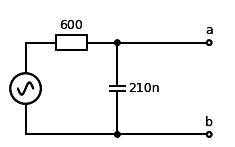

In [4]:
def rc_lowpass():
    c = circuit.Circuit(title="RC-tag")
    c.add_resistor("R1", n1="n_in", n2="n_out", value=600)
    c.add_capacitor("C1", n1="n_out", n2=c.gnd, value=210e-9)
    return c

with schem.Drawing() as d:
    V_in = d.add(elem.SourceSin(d='up'))
    R = d.add(elem.ResistorIEC(d='right', label='600'))
    d.add(elem.Dot())
    C = d.add(elem.Capacitor(d='down', botlabel='210n'))
    d.add(elem.Dot())
    d.add(elem.Line(to=V_in.start))
    d.add(elem.Line(d ='right', xy=R.end))
    d.add(elem.Dot(label='a', open=True))
    d.add(elem.Line(d='right', xy=C.end))
    d.add(elem.Dot(label='b', open=True))
    d.draw()

## 4-ed rendű Butterworth-féle aluláteresztő szűrő

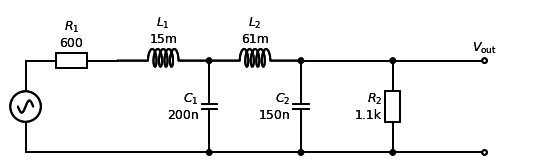

In [5]:
def butterworth_lowpass():
    c = circuit.Circuit(title="4-ed rendű Butterworth-féle aluláteresztő szűrő")
    c.add_resistor("R1", n1="n_in", n2="n2", value=600)
    c.add_inductor("L1", n1="n2", n2="n3", value=15e-3)
    c.add_capacitor("C1", n1="n3", n2=c.gnd, value=200e-9)
    c.add_inductor("L2", n1="n3", n2="n_out", value=61e-3)
    c.add_capacitor("C2", n1="n_out", n2=c.gnd, value=150e-9)
    c.add_resistor("R2", n1="n_out", n2=c.gnd, value=1.1e3)
    return c

with schem.Drawing() as d:
    V_in = d.add(elem.SourceSin(d='up'))
    R1 = d.add(elem.ResistorIEC(d='right', label='$R_1$\n600'))
    L1 = d.add(elem.Inductor2(d='right', label='$L_1$\n15m'))
    d.add(elem.Dot())
    C1 = d.add(elem.Capacitor(d='down', label='$C_1$\n200n'))
    d.add(elem.Dot())
    L2 = d.add(elem.Inductor2(d='right', xy=C1.start, label='$L_2$\n61m'))
    d.add(elem.Dot())
    C2 = d.add(elem.Capacitor(d='down', label='$C_2$\n150n'))
    d.add(elem.Dot())
    d.add(elem.Line(d='right', xy=C2.start))
    d.add(elem.Dot())
    R2 = d.add(elem.ResistorIEC(d='down', label='$R_2$\n1.1k'))
    d.add(elem.Dot())
    for i in range(4): d.add(elem.Line(d='left'))
    d.add(elem.Line(d='right', xy=R2.start))
    d.add(elem.Dot(label='$V_\mathrm{out}$', open=True))
    d.add(elem.Line(d='right', xy=R2.end))
    d.add(elem.Dot(open=True))
    d.draw()

## 4-ed rendű Butterworth-féle sáváteresztő szűrő

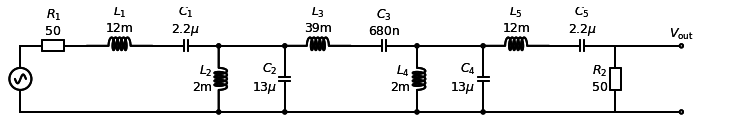

In [6]:
def butterworth_bandpass():
    c = circuit.Circuit('Butterworth-féle 1kHz-es sáváteresztő szűrő')
    c.add_resistor('R1', 'n_in', 'n2', 50.)
    c.add_inductor('L1', 'n2', 'n3', 12e-3)
    c.add_capacitor('C1', 'n3', 'n4', 2.2e-6)
    c.add_inductor('L2', 'n4', c.gnd, 2e-3)
    c.add_capacitor('C2', 'n4', c.gnd, 13e-6)
    c.add_inductor('L3', 'n4', 'n5', 39e-3)
    c.add_capacitor('C3', 'n5', 'n6', 680e-9)
    c.add_inductor('L4', 'n6', c.gnd, 2e-3)
    c.add_capacitor('C4', 'n6', c.gnd, 13e-6)
    c.add_capacitor('C5', 'n7', 'n_out', 2.2e-6)
    c.add_inductor('L5', 'n6', 'n7', 12e-3)
    c.add_resistor('R2', 'n_out', c.gnd, 50.)
    return c

with schem.Drawing() as d:
    V_in = d.add(elem.SourceSin(d='up'))
    R1 = d.add(elem.ResistorIEC(d='right', label='$R_1$\n50'))
    L1 = d.add(elem.Inductor2(d='right', label='$L_1$\n12m'))
    C1 = d.add(elem.Capacitor(d='right', label='$C_1$\n2.2$\mu$'))
    d.add(elem.Dot())
    L2 = d.add(elem.Inductor2(d='down', label='$L_2$\n2m'))
    d.add(elem.Dot())
    d.add(elem.Line(d='right', xy=L2.start))
    d.add(elem.Dot())
    C2 = d.add(elem.Capacitor(d='down', label='$C_2$\n13$\mu$'))
    d.add(elem.Dot())
    L3 = d.add(elem.Inductor2(d='right', xy=C2.start, label='$L_3$\n39m'))
    C3 = d.add(elem.Capacitor(d='right', label='$C_3$\n680n'))
    d.add(elem.Dot())
    L4 = d.add(elem.Inductor2(d='down', label='$L_4$\n2m'))
    d.add(elem.Dot())
    d.add(elem.Line(d='right', xy=L4.start))
    d.add(elem.Dot())
    C4 = d.add(elem.Capacitor(d='down', label='$C_4$\n13$\mu$'))
    d.add(elem.Dot())
    L5 = d.add(elem.Inductor2(d='right', xy=C4.start, label='$L_5$\n12m'))
    C5 = d.add(elem.Capacitor(d='right', label='$C_5$\n2.2$\mu$'))
    R2 = d.add(elem.ResistorIEC(d='down', label='$R_2$\n50'))
    for i in range(9): d.add(elem.Line(d='left'))
    d.add(elem.Line(d='right', xy=R2.start))
    d.add(elem.Dot(label='$V_\mathrm{out}$', open=True))
    d.add(elem.Line(d='right', xy=R2.end))
    d.add(elem.Dot(open=True))
    d.config(inches_per_unit=0.36)
    d.draw()

# Feladatok

## 1. részfeladat - Mérőjelek szimulációja

Analóg áramkörök kísérleti, szimulált és analitikus vizsgálatakor gyakran alkalmazunk ún. mérőjeleket. 

Írjunk függvényeket, melyek megvalósítják

* a tetszőleges frekvenciájú, amplitúdójú és fázisú szinuszos mérőjelet,
* a tetszőleges periódusidejű és amplitúdójú négyszögjelet,
* az egységimpulzust valamint
* az egységugrást.

A feladat későbbi részeinek megkönnyítése érdekében kövessük azt a szokást, hogy úgy írjuk meg ezeket a mérőjel-függvényeket, hogy akár egyszerre több időpontot is ki tudjanak értékelni, ha ezek a $t$ időpontok `array()`ben vannak eltárolva, és a függvény ezeket így kapja meg egyben.

Ábrázoljuk a mérőjeleket!

# órai segítségek
### sinuszos jelnél váltsuk át a körfkrevenciát
### az inteporálásnál elég sűrűn legyen, dirac deltánál benne legyen aza pont ahol ugrik egyez az interpolációnal
### ÁBRAFELIRAT
### ha kimeneti jel pici szorozzuk fel és jelezzük
### fehérzajnál ellenőrzés a fourier ha konstans akkor sikerült!
### nincsen képzetes

In [7]:
# mérőjeleket megvalósítő függvények
def sin(f,A,fi,t):
    omega=2*np.pi*f
    hely=A*np.sin(omega*t+fi)
    return(hely)


def negy(A,T,t):
    hely=A*np.sign(np.sin((2*np.pi*t)/T))
    return(hely)


def egys(t,t0=0):
    return(1*(t==t0))


def heavy(t):
    A=np.zeros(len(t))
    
    for i in range(len(A)):
        if t[i]>0:
            A[i]=1
        else:
            A[i]=0
    return(A)

In [8]:
#plotoláshoz előre összerakom
plotszin=(sin(100,1,0.5,np.linspace(-1,1,100)))#100 frekvencia,1 amp, 0.5 phi, és 100 ponton
plotnegy=(negy(10,0.5,np.linspace(-1,1,10000)))
plotegys=np.linspace(-1,1,1001),egys(np.linspace(-1,1,1001))
ploths=(np.linspace(-1,1,100),heavy(np.linspace(-1,1,100)))

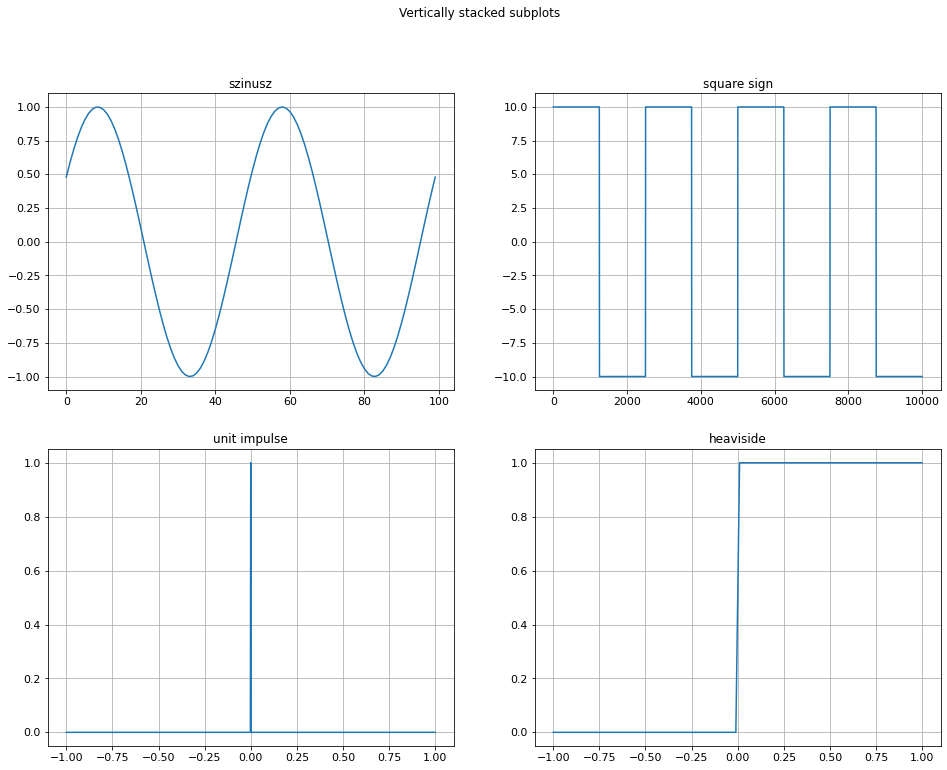

In [9]:
fig, axs = plt.subplots(2,2,figsize=(16,12))
fig.suptitle('Vertically stacked subplots')

axs[0,0].plot(plotszin)
axs[0,0].set_title("szinusz")
axs[0,0].grid()


axs[0,1].plot(plotnegy)
axs[0,1].set_title("square sign")
axs[0,1].grid()


axs[1,0].plot(*plotegys)
axs[1,0].set_title("unit impulse")
axs[1,0].grid()


axs[1,1].plot(*ploths)
axs[1,1].set_title("heaviside")
axs[1,1].grid()


## 2. rész - Mérőjelekre adott válaszok analízise

Szimuláljuk a mérőjelek hatását a fenti függvényekben definiált áramkörökre:

* RC aluláteresztő szűrő,
* Butterworth-féle aluláteresztő szűrő,
* Butterworth-féle 1kHz-es sáváteresztő szűrő.

Segítségül a hívási szintaxist megmutatjuk az alábbi példán, ahol az RC aluláteresztő szűrő válaszfüggvényét szimuláljuk 1 kHz-es szinuszos gerjesztés esetén.

Minhárom példa áramkör alapparaméterei olyanok, hogy a 600 Hz - 5 kHz tartományban van a lényegi viselkedés, de szebb ábráért érdemes valamivel tovább menni.

A helyes működés érdekében okosan kell a mérőjelek paramétereit megválasztani. Az áramkörök érdekes tartományát figyelembe véve, megfelelő időskálán vizsgáljuk a működést, és a periódikus jelek frekvenciáját is helyesen válasszuk meg! Az is előfordulhat, hogy a példában rögzített értékeken módosítani kell,  például a `run_transient()`ben megadott `tstop` értékén.
Olyan hosszan ábrázoljuk, amíg lényeges változást látunk, pl. lecseng a jel, vagy periódikus, de az amplitúdója változik.

A szimulációt elvégző `run_transient()` függvény második argumentumaként várja a bemenő jelet leíró függvényt.
Itt két probléma léphet fel:

(i) Egyik probléma, hogy ez a függvény csak egy argumentumú lehet, az idő az argumentuma. Tehát az első feladatban általánosan elkészített függvényeket, amelyek további paramétereket is várnak, ügyesen kell ennek a függvénynek átadni. 
A szinuszos mérőjel esetén ezt úgy is megoldhatjuk, hogy a kért függvényt ún. `lambda` kifejezéssel helyettesítjük, vagy aki jártas a `python` dekorátorok világában, azokkal is megoldhatja. A lambda kifejezéses megoldásra példa az alábbi:

Text(0, 0.5, 'V')

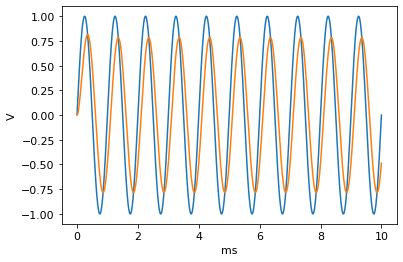

In [10]:
c = rc_lowpass()
t, s, r = run_transient(c, lambda t: np.sin(1000 * 2 * np.pi * t), tstart=0, tstop=10e-3)

plt.plot(t * 1e3, s)
plt.plot(t * 1e3, r)
plt.xlabel("ms")
plt.ylabel("V")

(ii) Egy másik probléma az, hogy az áramkörszimulátor hibát ad, ha a vizsgáló jelben szakadás vagy ugrás van. 
Így mind az egységurás, mind az impulzus esetén ügyeljünk arra, hogy ezeket a jeleket megfelelően közelítsük. 
Célszerű a mérőjeleket *folytonossá* alakítani például az `interp1d` osztály segítségével. Ezzel egyben a paraméterátadással kapcsolatos kérdés is megoldható. Ha kiolvassuk a bemenő jel értékeit egy elég sűrű pontsorozaton, akkor az `interp1d` függvény segítségével pl lineárisan interpolálhatjuk ezeket az értékeket. Az `interp1d` által visszaadott függvényt meg tudjuk hívni a megadott tartományon belüli tetszőleges értékkel az interpolált értékek kiolvasása céljából. 

Az interpolált függvényt közvetlen beadhatjuk a `run_transient` függvénynek a korábbi példa szerinti lambda forma helyén. (Persze ekkor a beírt függvény neve után ne írjunk zárójeleket, mert a függvény azonosítóját kell átadni, nem egy lefuttatásának eredményét.) Figyeljünk, hogy a feladat megoldásához az interpolált függvényt egy megfelelő időskálájú értéksorozatból hozzuk létre.

Meg kell említeni még, hogy a `run_transient()` kicsivel `tstop` után is kiértékelheti a bemenő jel függvényét, 
tehát erre fel kell készíteni az implementációt, hogy ilyenkor se keletkezzen hiba.

In [11]:
c_0 = rc_lowpass() #előre megcsinálva a szűrőkre
c_1 = butterworth_bandpass()
c_2 = butterworth_lowpass()

## szinuszos

In [12]:
t = np.linspace(-1, 1, 500)  # plothoz előre minden
szinuszos=sin(1000,1,0,t)
t_sin_0, s_sin_0, r_sin_0 = run_transient(c_0, lambda t: sin(1000,1,0,t), tstart=0, tstop=10e-3)
L1=t_sin_0 * 1e3, s_sin_0
L2=t_sin_0 * 1e3, r_sin_0
t_sin_1, s_sin_1, r_sin_1 = run_transient(c_1, lambda t: sin(1000,1,0,t), tstart=0, tstop=10e-3)
Bb1=t_sin_1 * 1e3, s_sin_1
Bb2=t_sin_1 * 1e3, r_sin_1
t_sin_2, s_sin_2, r_sin_2 = run_transient(c_2, lambda t: sin(1000,1,0,t), tstart=0, tstop=10e-3)
Bl1=t_sin_2 * 1e3, s_sin_2
Bl2=t_sin_2 * 1e3, r_sin_2

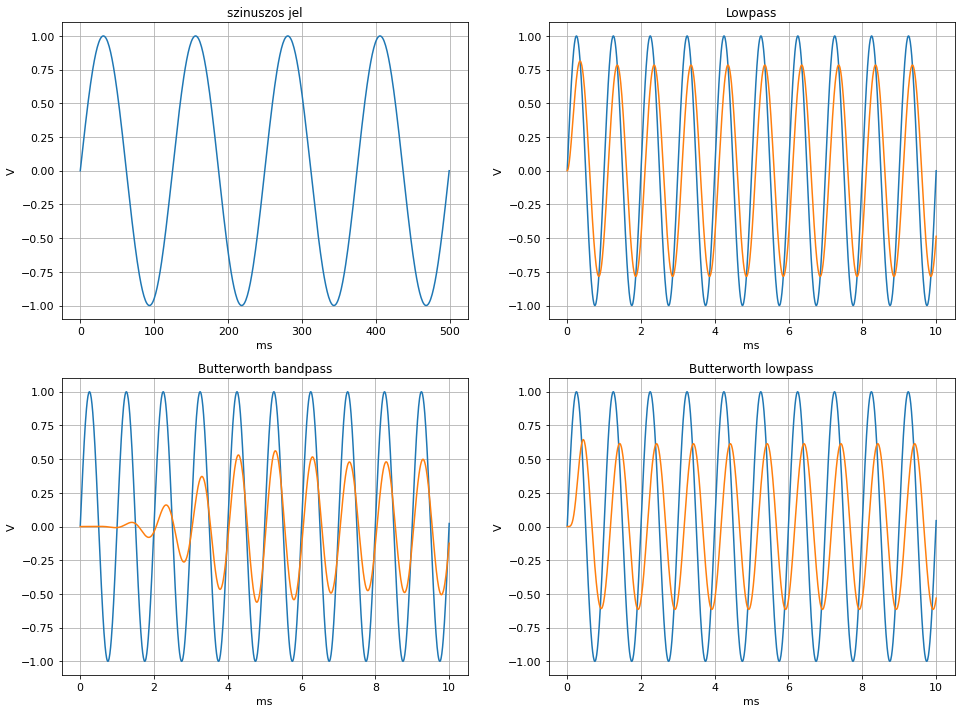

In [13]:
fig, axs = plt.subplots(2,2,figsize=(16,12))


axs[0,0].set_title("szinuszos jel")
axs[0,0].plot(szinuszos)
axs[0,0].set_xlabel("ms")
axs[0,0].set_ylabel("V")
axs[0,0].grid()


axs[0,1].set_title("Lowpass")
axs[0,1].plot(*L1)
axs[0,1].plot(*L2)
axs[0,1].set_xlabel("ms")
axs[0,1].set_ylabel("V")
axs[0,1].grid()


axs[1,0].set_title("Butterworth bandpass")
axs[1,0].plot(*Bb1)
axs[1,0].plot(*Bb2)
axs[1,0].set_xlabel("ms")
axs[1,0].set_ylabel("V")
axs[1,0].grid()


axs[1,1].set_title("Butterworth lowpass")
axs[1,1].plot(*Bl1)
axs[1,1].plot(*Bl2)
axs[1,1].set_xlabel("ms")
axs[1,1].set_ylabel("V")
axs[1,1].grid()

##  square sign

In [14]:
t2 = np.linspace(-1, 1, 10001)
sqi = interp1d(t2, negy(1,0.5,t2), kind = 'linear')

In [15]:
t_negy_0, s_negy_0, r_negy_0 = run_transient(c_0, sqi, tstart=0, tstop=10e-3)
L3=t_negy_0 * 1e3, s_negy_0
L4=(t_negy_0 * 1e3, r_negy_0)
t_negy_1, s_negy_1, r_negy_1 = run_transient(c_1,sqi, tstart=0, tstop=10e-3)
Bb3=t_negy_1 * 1e3, s_negy_1
Bb4=t_negy_1 * 1e3, r_negy_1
t_negy_2, s_negy_2, r_negy_2 = run_transient(c_2,sqi, tstart=0, tstop=10e-3)
Bl3=t_negy_2 * 1e3, s_negy_2
Bl4=t_negy_2 * 1e3, r_negy_2

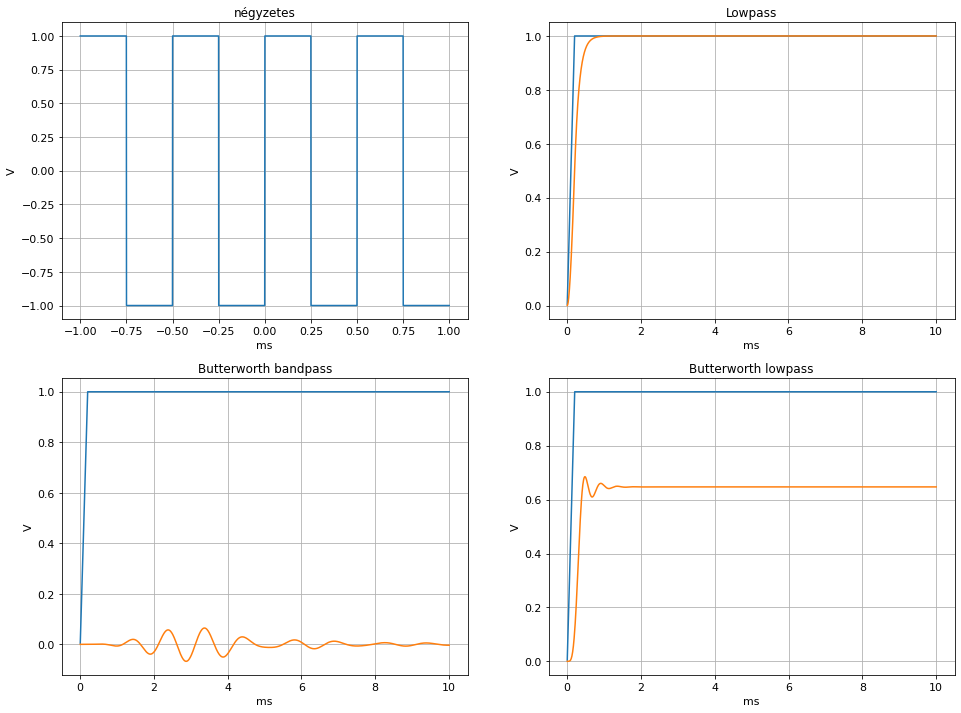

In [16]:
fig, axs = plt.subplots(2,2,figsize=(16,12))


axs[0,0].set_title("négyzetes")
axs[0,0].plot(t2,sqi(t2))
axs[0,0].set_xlabel("ms")
axs[0,0].set_ylabel("V")
axs[0,0].grid()


axs[0,1].set_title("Lowpass")
axs[0,1].plot(*L3)
axs[0,1].plot(*L4)
axs[0,1].set_xlabel("ms")
axs[0,1].set_ylabel("V")
axs[0,1].grid()


axs[1,0].set_title("Butterworth bandpass")
axs[1,0].plot(*Bb3)
axs[1,0].plot(*Bb4)
axs[1,0].set_xlabel("ms")
axs[1,0].set_ylabel("V")
axs[1,0].grid()


axs[1,1].set_title("Butterworth lowpass")
axs[1,1].plot(*Bl3)
axs[1,1].plot(*Bl4)
axs[1,1].set_xlabel("ms")
axs[1,1].set_ylabel("V")
axs[1,1].grid()

# egységimpulzus

In [17]:
t3 = np.linspace(-1, 1, 10001)

kdi = interp1d(t3, egys(t3), kind = 'linear')

In [18]:
t_egy0, s_egy0, r_egy0 = run_transient(c_0, kdi, tstart=0, tstop=10e-3)
L5=t_egy0 * 1e3, s_egy0
L6=t_egy0 * 1e3, r_egy0
t_egy1, s_egy1, r_egy1 = run_transient(c_1, kdi, tstart=0, tstop=10e-3)
Bb5=t_egy1 * 1e3, s_egy1
Bb6=t_egy1 * 1e3, r_egy1
t_egy2, s_egy2, r_egy2 = run_transient(c_2, kdi, tstart=0, tstop=10e-3)
Bl5=t_egy2 * 1e3, s_egy2
Bl6=t_egy2 * 1e3, r_egy2

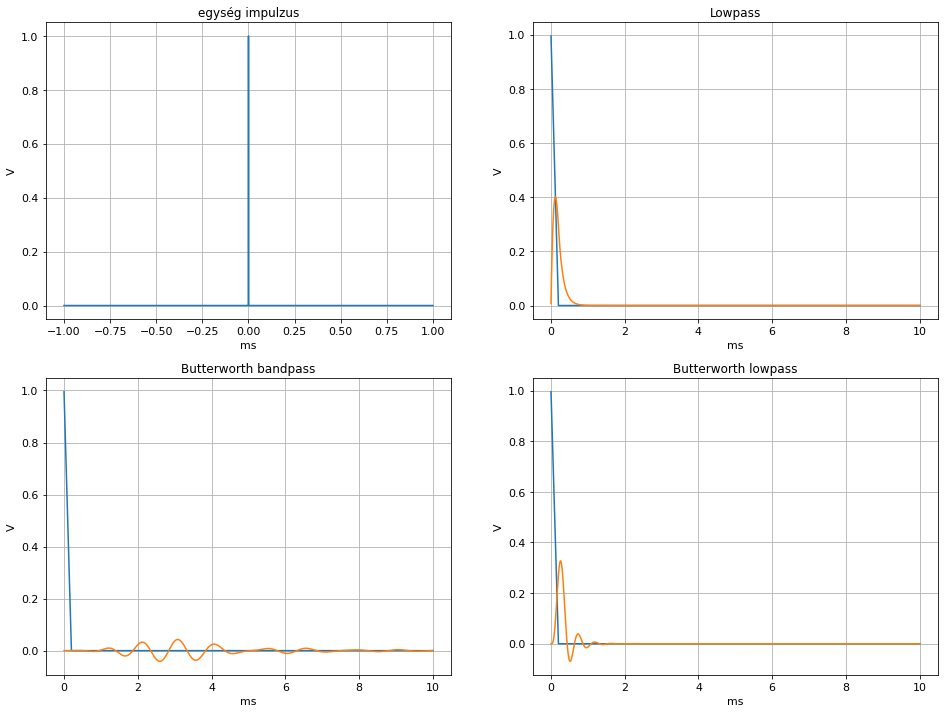

In [19]:
fig, axs = plt.subplots(2,2,figsize=(16,12))


axs[0,0].set_title("egység impulzus")
axs[0,0].plot(t3,kdi(t3))
axs[0,0].set_xlabel("ms")
axs[0,0].set_ylabel("V")
axs[0,0].grid()


axs[0,1].set_title("Lowpass")
axs[0,1].plot(*L5)
axs[0,1].plot(*L6)
axs[0,1].set_xlabel("ms")
axs[0,1].set_ylabel("V")
axs[0,1].grid()


axs[1,0].set_title("Butterworth bandpass")
axs[1,0].plot(*Bb5)
axs[1,0].plot(*Bb6)
axs[1,0].set_xlabel("ms")
axs[1,0].set_ylabel("V")
axs[1,0].grid()


axs[1,1].set_title("Butterworth lowpass")
axs[1,1].plot(*Bl5)
axs[1,1].plot(*Bl6)
axs[1,1].set_xlabel("ms")
axs[1,1].set_ylabel("V")
axs[1,1].grid()

# Heaviside

In [20]:
t4 = np.linspace(-1, 1, 10001)
hsi = interp1d(t4, heavy(t4), kind = 'linear')

In [21]:
t_hs0, s_hs0, r_hs0 = run_transient(c_0, hsi, tstart=0, tstop=10e-3)
L7=t_hs0 * 1e3, s_hs0
L8=t_hs0 * 1e3, r_hs0
t_hs1, s_hs1, r_hs1 = run_transient(c_1, hsi, tstart=0, tstop=10e-3)
Bb7=t_hs1 * 1e3, s_hs1
Bb8=t_hs1 * 1e3, r_hs1
t_hs2, s_hs2, r_hs2 = run_transient(c_2, hsi, tstart=0, tstop=10e-3)
Bl7=t_hs2 * 1e3, s_hs2
Bl8=t_hs2 * 1e3, r_hs2


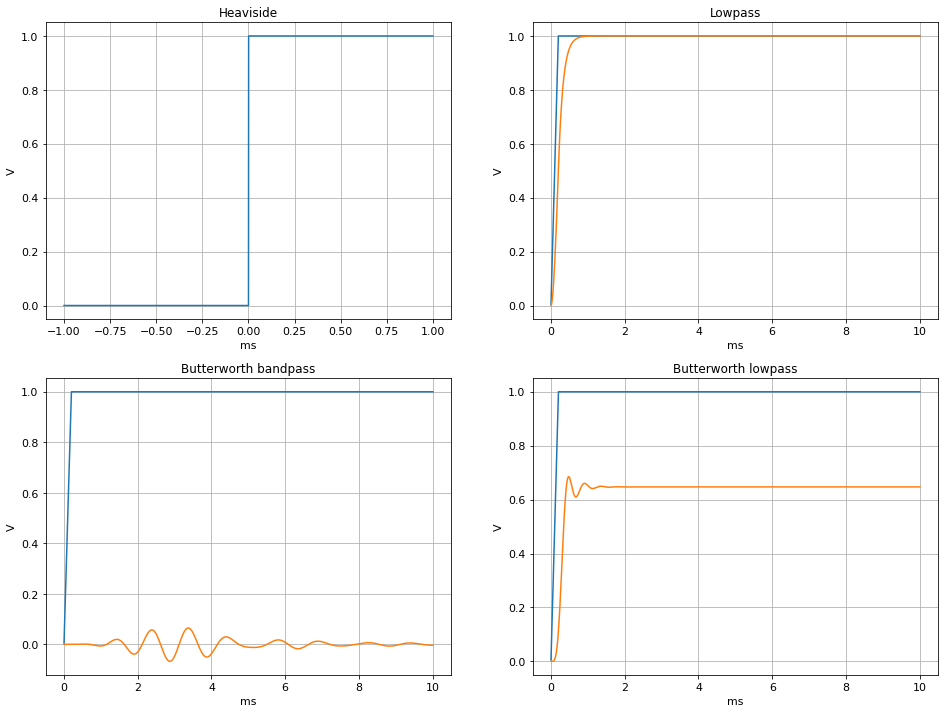

In [22]:
fig, axs = plt.subplots(2,2,figsize=(16,12))


axs[0,0].set_title("Heaviside")
axs[0,0].plot(t4,hsi(t4))
axs[0,0].set_xlabel("ms")
axs[0,0].set_ylabel("V")
axs[0,0].grid()


axs[0,1].set_title("Lowpass")
axs[0,1].plot(*L7)
axs[0,1].plot(*L8)
axs[0,1].set_xlabel("ms")
axs[0,1].set_ylabel("V")
axs[0,1].grid()


axs[1,0].set_title("Butterworth bandpass")
axs[1,0].plot(*Bb7)
axs[1,0].plot(*Bb8)
axs[1,0].set_xlabel("ms")
axs[1,0].set_ylabel("V")
axs[1,0].grid()


axs[1,1].set_title("Butterworth lowpass")
axs[1,1].plot(*Bl7)
axs[1,1].plot(*Bl8)
axs[1,1].set_xlabel("ms")
axs[1,1].set_ylabel("V")
axs[1,1].grid()

## 3. rész - Átviteli függvény meghatározása

Szimuláljuk a két összetettebb rendszer kimenetét különböző frekvenciájú szinuszos bemenőjelek esetén. Határozzuk meg a kimenet amplitúdóját és fáziseltolódását a frekvencia függvényében. Ügyeljünk arra, hogy a kimeneti jel amplitúdóját a tranziens szakasz eltűnése után kell megmérni!

Ábrázoljuk az átviteli függvényeket és az ábrák elemzésével összegezzük a tapasztaltakat.

In [23]:
# Átviteli függvény meghatározása és ábrázolása a Butterworth-féle Bandpass szűrőre
t5 = np.linspace(0, 60, 10001)
t_sin_1, s_sin_1, r_sin_1 = run_transient(c_1, lambda t: sin(600,1,0,t), tstart=0, tstop=5.5e-2)

In [24]:
max_index = [i for i, j in enumerate(r_sin_1[3000:]) if j == max(r_sin_1[3000:])][0]
min_index = [i for i, j in enumerate(r_sin_1[3000:]) if j == min(r_sin_1[3000:])][0]

# Itt számolom tranziens szakasz után, ahol jel és válasz egyenlő 0-val és ezeknek kapom vissza a ind, val-ját
jel_null = min(enumerate(s_sin_1[3150:3250]), key=lambda x: abs(x[1]-0))
valasz_null = min(enumerate(r_sin_1[3150:3250]), key=lambda x: abs(x[1]-0))

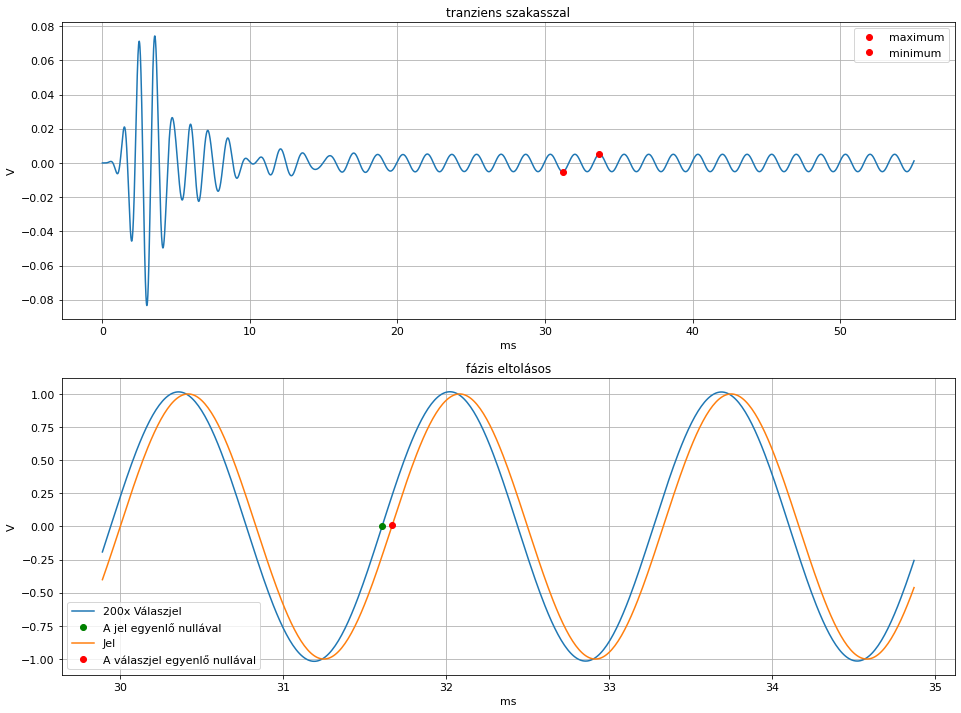

In [25]:
fig, axs = plt.subplots(2,1,figsize=(16,12))
axs[0].set_title("tranziens szakasszal")
axs[0].plot(t_sin_1 * 1e3, r_sin_1)
axs[0].set_xlabel("ms")
axs[0].set_ylabel("V")
axs[0].plot(t_sin_1[3380] * 1e3,r_sin_1[3380],'ro',label='maximum')
axs[0].plot(t_sin_1[3130] * 1e3,r_sin_1[3130],'ro',label='minimum')
axs[0].legend()
axs[0].grid()
# Átviteli függvény ábrázolása
axs[1].set_title("fázis eltolásos")
axs[1].plot(t_sin_1[3000:3500] * 1e3, 200*r_sin_1[3000:3500], label="200x Válaszjel")
axs[1].plot(t_sin_1[3150+valasz_null[0]] * 1e3,r_sin_1[3150+valasz_null[0]],'o',color = 'g' ,label='A jel egyenlő nullával')
axs[1].set_xlabel("ms")
axs[1].set_ylabel("V")
axs[1].plot(t_sin_1[3000:3500] * 1e3, s_sin_1[3000:3500], label="Jel")
axs[1].plot(t_sin_1[3150+jel_null[0]] * 1e3,s_sin_1[3150+jel_null[0]],'o',color = 'r',label='A válaszjel egyenlő nullával')
axs[1].legend()
axs[1].grid()

In [26]:
print("Amplitudó: " + str(abs(r_sin_1[3000+max_index])+abs(r_sin_1[3000+min_index])) + " V")
print("Eltolódása: " + str(abs(valasz_null[0])) + " ms")

Amplitudó: 0.0101690231569685 V
Eltolódása: 22 ms


In [27]:

tranzutan = 3000
amplitude_min = tranzutan + [i for i, j in enumerate(r_sin_1[tranzutan:]) if j == min(r_sin_1[tranzutan:])][0]
amplitude_max = tranzutan + [i for i, j in enumerate(r_sin_1[tranzutan:]) if j == max(r_sin_1[tranzutan:])][0]
amplitude = []
phase = []
frequency = []
for i in tqdm(range(0,900,10)):
    t_szin, s_szin, r_szin = run_transient(c_1, lambda t:sin(600+i, 1, 0,t), tstart=0, tstop=5e-2)
    frequency.append(600+i)
    # max, min érték
    amplitude_max = tranzutan + [i for i, j in enumerate(r_szin[3000:]) if j == max(r_szin[3000:])][0]
    amplitude_min = tranzutan + [i for i, j in enumerate(r_szin[3000:]) if j == min(r_szin[3000:])][0]
    amplitude.append(abs(r_szin[amplitude_max])+abs(r_szin[amplitude_min]))
    # a jel és válasz itt egyenlő nullával
    phase_null_signal = min(enumerate(s_szin[amplitude_min:amplitude_min+100]), key=lambda x: abs(x[1]-0))
    phase_null_response = min(enumerate(r_szin[amplitude_min:amplitude_min+100]), key=lambda x: abs(x[1]-0))
    phase.append(abs(phase_null_response[0]-phase_null_signal[0]))
frequency_str = [str(x) for x in frequency]

  0%|          | 0/90 [00:00<?, ?it/s]

Text(0, 0.5, 'V')

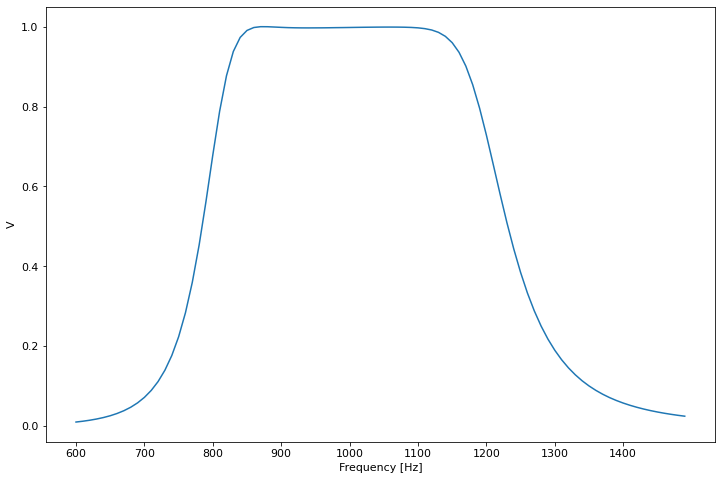

In [28]:
plt.figure(figsize=(12,8))
plt.plot(amplitude)
plt.xticks(range(0, len(frequency), 10), frequency_str[::10])
plt.xlabel('Frequency [Hz]')
plt.ylabel("V")

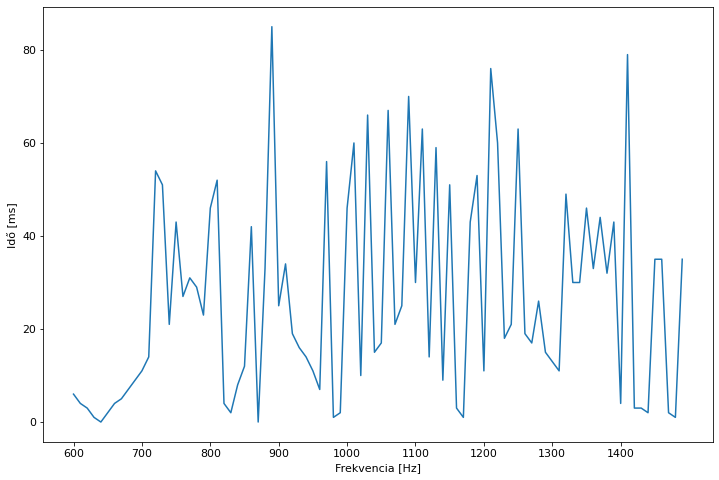

In [29]:
plt.figure(figsize=(12,8))
plt.xticks(range(0, len(frequency), 10), frequency_str[::10])
plt.ylabel("Idő [ms]")
plt.xlabel('Frekvencia [Hz]')
plt.plot(phase)

In [30]:
# Átviteli függvény meghatározása és ábrázolása a Butterworth Lowpass szűrőre
t6 = np.linspace(0, 60, 10001)
t_sin_2, s_sin_2, r_sin_2 = run_transient(c_2, lambda t: sin(600,1,0,t), tstart=0, tstop=5.5e-2)

In [31]:
max_index = [i for i, j in enumerate(r_sin_2[1950:]) if j == max(r_sin_2[1950:])][0]
min_index = [i for i, j in enumerate(r_sin_2[1950:]) if j == min(r_sin_2[1950:])][0]

# Itt számolom tranziens szakasz után, ahol jel és válasz egyenlő 0-val és ezeknek kapom vissza a ind, val-ját
jel_null2 = min(enumerate(s_sin_2[315:325]), key=lambda x: abs(x[1]-0))
valasz_null2 = min(enumerate(r_sin_2[315:325]), key=lambda x: abs(x[1]-0))

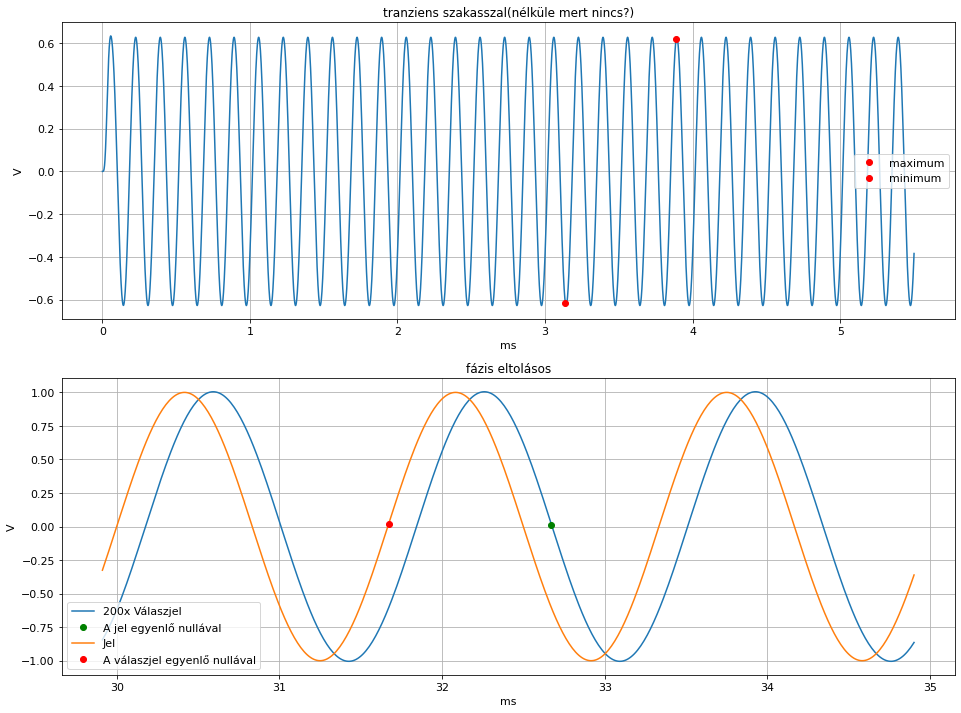

In [32]:
fig, axs = plt.subplots(2,1,figsize=(16,12))
axs[0].set_title("tranziens szakasszal(nélküle mert nincs?)")
axs[0].plot(t_sin_2 * 1e2, r_sin_2)
axs[0].set_xlabel("ms")
axs[0].set_ylabel("V")
axs[0].plot(t_sin_2[397] * 1e3,r_sin_2[397],'ro',label='maximum')
axs[0].plot(t_sin_2[322] * 1e3,r_sin_2[313],'ro',label='minimum')
axs[0].legend()
axs[0].grid()
# Átviteli függvény ábrázolása
axs[1].set_title("fázis eltolásos")
axs[1].plot(t_sin_2[3000:3500] * 1e3, 1.6*r_sin_2[3000:3500], label="200x Válaszjel")
axs[1].plot(t_sin_2[3267+valasz_null2[0]] * 1e3,r_sin_2[3267+valasz_null2[0]],'o',color = 'g' ,label='A jel egyenlő nullával')
axs[1].set_xlabel("ms")
axs[1].set_ylabel("V")
axs[1].plot(t_sin_2[3000:3500] * 1e3, s_sin_2[3000:3500], label="Jel")
axs[1].plot(t_sin_2[3167+jel_null2[0]] * 1e3,s_sin_2[3167+jel_null2[0]],'o',color = 'r',label='A válaszjel egyenlő nullával')
axs[1].legend()
axs[1].grid()

In [33]:
print("Amplitudó: " + str(abs(r_sin_2[397+max_index])+abs(r_sin_2[313+min_index])) + " V")
print("Eltolódása: " + str(abs(valasz_null2[0])) + " ms")

Amplitudó: 0.5407021591225782 V
Eltolódása: 9 ms


In [34]:
tranzutan = 600
amplitude_min2 = tranzutan + [i for i, j in enumerate(r_sin_2[tranzutan:]) if j == min(r_sin_2[tranzutan:])][0]
amplitude_max2 = tranzutan + [i for i, j in enumerate(r_sin_2[tranzutan:]) if j == max(r_sin_2[tranzutan:])][0]
amplitude2 = []
phase2 = []
frequency2 = []
for i in tqdm(range(0,3000,20)):
    t_szin2, s_szin2, r_szin2 = run_transient(c_2, lambda t:sin(600+i, 1, 0,t), tstart=0, tstop=8e-3)
    frequency2.append(600+i)
    # max, min érték
    amplitude_max2 = tranzutan + [i for i, j in enumerate(r_szin2[600:]) if j == max(r_szin2[600:])][0]
    amplitude_min2 = tranzutan + [i for i, j in enumerate(r_szin2[600:]) if j == min(r_szin2[600:])][0]
    amplitude2.append(abs(r_szin2[amplitude_max2])+abs(r_szin2[amplitude_min2]))
    # a jel és válasz itt egyenlő nullával
    phase_null_signal = min(enumerate(s_szin2[amplitude_min2:amplitude_min2+100]), key=lambda x: abs(x[1]-0))
    phase_null_response = min(enumerate(r_szin2[amplitude_min2:amplitude_min2+100]), key=lambda x: abs(x[1]-0))
    phase2.append(abs(phase_null_response[0]-phase_null_signal[0]))
frequency_str2 = [str(x) for x in frequency]

  0%|          | 0/150 [00:00<?, ?it/s]

Text(0, 0.5, 'V')

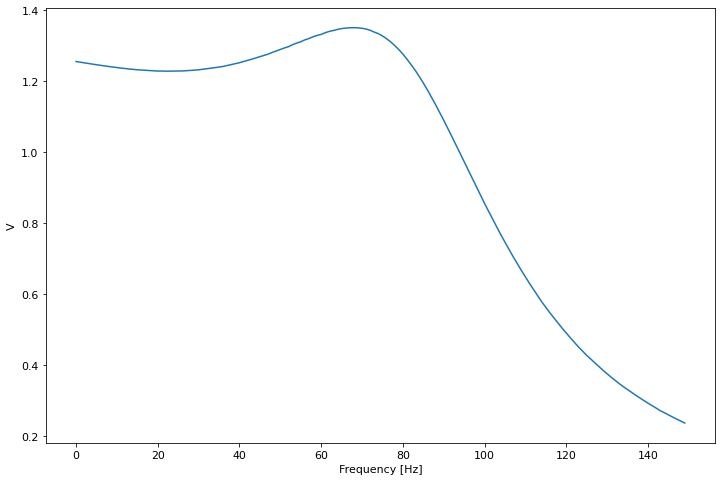

In [35]:
plt.figure(figsize=(12,8))
plt.plot(amplitude2)
#plt.xticks(range(0, len(frequency2), 10), frequency_str2[::10])
plt.xlabel('Frequency [Hz]')
plt.ylabel("V")

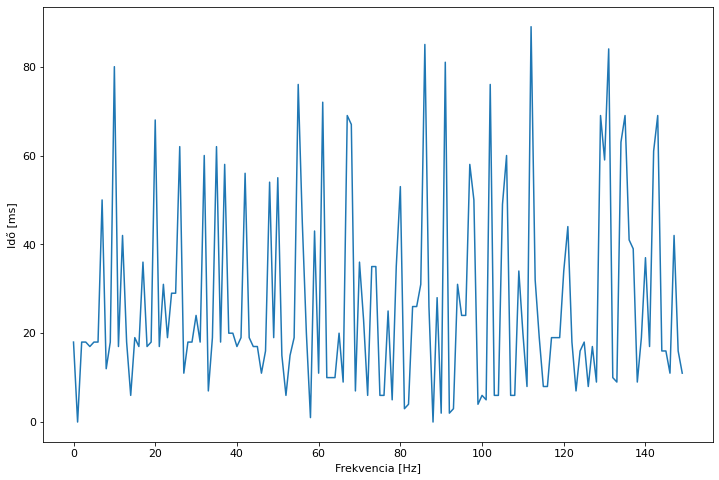

In [36]:
plt.figure(figsize=(12,8))
#plt.xticks(range(0, len(frequency2), 10), frequency_str2[::10])
plt.ylabel("Idő [ms]")
plt.xlabel('Frekvencia [Hz]')
plt.plot(phase2)

#### Tapasztalatok szövegezése

Bár a számolásnál azt mondja nekem 0 a különbség, szemmel láthatóan nagyobb az eltolódás a sáváteresztőnél

## 4. rész - Az impulzusválasz tulajdonságainak vizsgálata

## 4.a
Az elméletből ismert, hogy a 3. részben meghatározott átviteli függvény és a fázistolás frekvenciafüggése önmagában az impulzusválaszból  megkapható, mégpedig az impulzusválasz Fourier transzformálásával.
Próbáljuk ezt ki a Butterworth-féle sáváteresztő szűrőn, azaz
szimuláljuk e szűrő impulzusra adott válaszát elegendően hosszan! Határozzuk meg az impulzusválasz Fourier-transzformáltját!
Állítsuk elő belőle az átviteli függvényt, és ábrázoljuk egy ábrában az előző feladatban meghatározott átviteli függvénnyel!

Itt hasonló problémával találkozunk, mint amilyennel egy korábbi feladatnál. Mivel a szimuláció időben nem egyenletes lépésközű adatsort ad, ahhoz, hogy a Fourier-transzformáltját tudjuk venni, át kell mintavételezni egyenletes lépésközzel. Ezt megint az `interp1d` függvénnyel tudjuk megtenni. A jelalakot most érdemes pontosabban közelíteni egy harmadrendű spline segítségével, amely az eredeti adatpontokban simán folytatódó függvényalakot valósít meg.

/opt/conda/lib/python3.8/site-packages/ahkab/transient.py:361: RuntimeWarning: overflow encountered in double_scalars
  new_value = ((aerror[index, 0] + rerror[index, 0]*abs(x[index, 0])) / lte[index, 0]) \


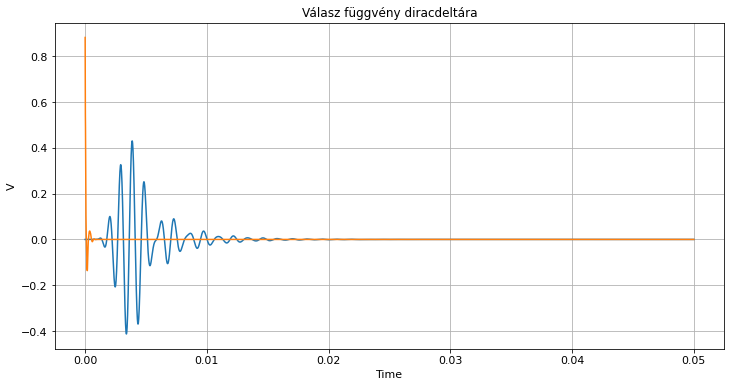

In [37]:
# Átinterpolált impulzusválasz ábrája
t6 = np.linspace(-1,1,100001)
mero_egysegimp_interp = interp1d(t6,egys(t6), kind = 'cubic')
t_imp1, s_imp1, r_imp1 = run_transient(c_1, mero_egysegimp_interp, tstart=0, tstop=5e-2)
tsok=np.linspace(0,5e-2,len(t_imp1))
impu=interp1d(tsok,r_imp1,kind='cubic')

plt.figure(figsize=(12, 6))
plt.title("Válasz függvény diracdeltára")
plt.xlabel('Time')
plt.ylabel('V')
plt.plot(tsok,100*impu(tsok))
plt.plot(tsok,s_imp1)
#plt.ylim(-0.005,0.02)
plt.grid(True)

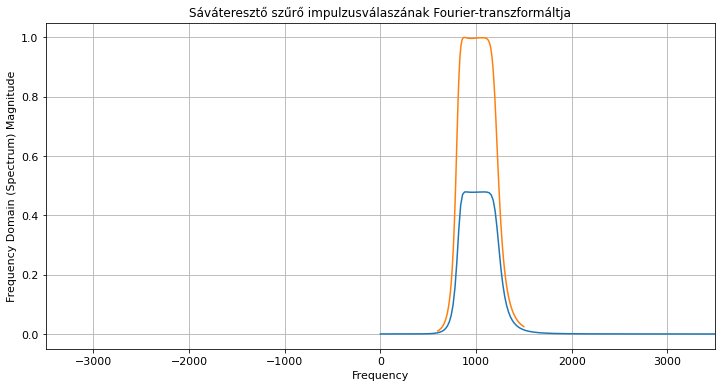

In [38]:
# Átinterpolált impulzusválasz ábrája
from numpy.fft import *


Fjel6=rfft(impu(tsok))
freq6 = rfftfreq(len(tsok),tsok[1]-tsok[0])
plt.figure(figsize=(12, 6))
plt.plot(freq6,abs(Fjel6))
plt.plot(np.linspace(600,1500,len(amplitude)),amplitude)
plt.title("Sáváteresztő szűrő impulzusválaszának Fourier-transzformáltja")
plt.xlabel('Frequency')
plt.ylabel('Frequency Domain (Spectrum) Magnitude')
plt.xlim(-3500,3500)
plt.grid(True)





#### Mit várunk el, és mit taptasztaltunk?

Azt várom el ugyanaz legyen, vagy legalábbis közel, kb. az is történik

## 4.b
Szintén ismert, hogy egy lineáris rendszernek tetszőlegesen választott bemenő jelre való válasza megkapható úgy is, ha a rendszerről csak az impulzusválaszát tudjuk. Az impulzusválasz és a választott bemenő jel konvolúcióját kell kiszámolni.
Próbáljuk ezt ki a Butterworth-féle aluláteresztő szűrő és négyszögjel esetére!

Az említett konvolúciót a numpy.convolve függvény segítségével tudjuk kiszámítani. Ehhez megint egyenletes, és egymással azonos lépésközzel kell venni a konvolváltatott jeleket, tehát az impulzusválaszt át kell mintavételezni egyenletes lépésközzel.
Bemenő jelként használjuk a 2. részben is használt periódikus négyszögjelet. Tehát vegyük a korábban már használt négyszögjel értékeit az előző lépésben meghatározott időbeli rácson. Hasonlítsuk össze a konvolúcióra kapott eredményt egy ábrában a 2. feladatrészben a négyszögjelre kapott válasszal!

In [39]:
t7 = np.linspace(-1,1,10001)
t_imp2, s_imp2, r_imp2 = run_transient(c_2, mero_egysegimp_interp, tstart=-10e-3, tstop=5e-2)
int1=t_imp2* 1e3,r_imp2
int2=t_imp2* 1e3,s_imp2
t_sqi3, s_sqi3, r_sqi3 = run_transient(c_2, sqi, tstart=-10e-3, tstop=5e-2)
int3=(1e5*t_sqi3,1e1*r_sqi3)
int4=t_sqi3,s_sqi3
t8 = np.linspace(-1, 1, 10000)
t_imp, s_imp, r_imp = run_transient(c_2, kdi, tstart=0, tstop=10e-3)
int5=t_imp * 1e3, s_imp
int6=t_imp * 1e3, r_imp
conv=(np.convolve(r_imp, s_negy_2))

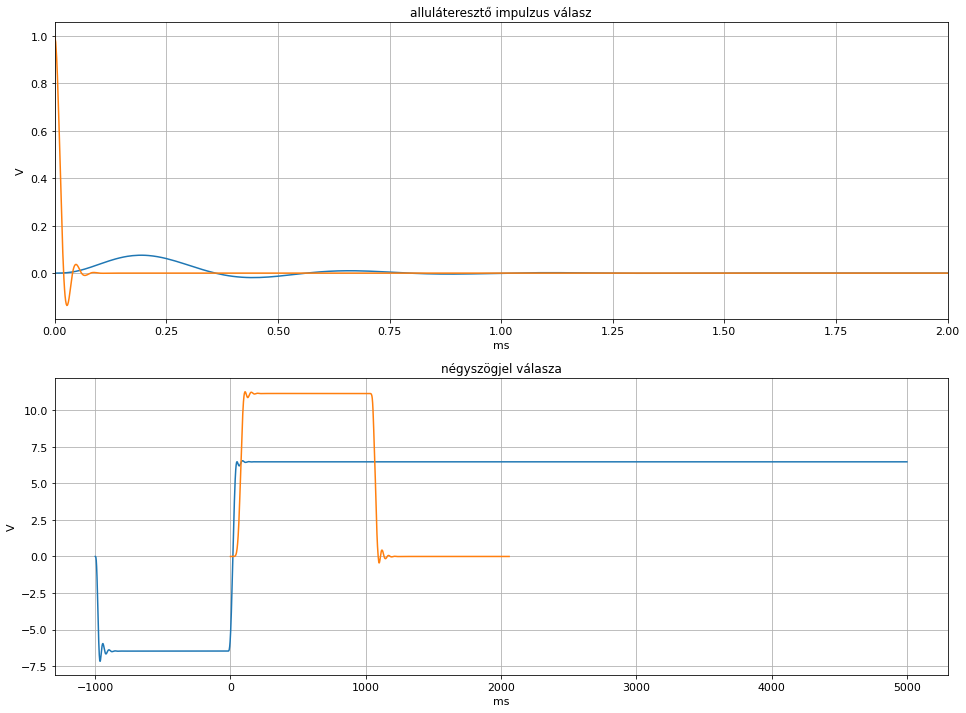

In [40]:
fig, axs = plt.subplots(2,1,figsize=(16,12))

axs[0].set_title("alluláteresztő impulzus válasz")
axs[0].plot(*int1)
axs[0].plot(*int2)
axs[0].set_xlabel("ms")
axs[0].set_ylabel("V")
axs[0].set_xlim(0,2)
axs[0].grid()

axs[1].set_title("négyszögjel válasza")
axs[1].plot(*int3)
axs[1].plot(conv)
axs[1].set_xlabel("ms")
axs[1].set_ylabel("V")
axs[1].grid()


Itt nem vagyok benne biztos lejjebb mint csináltam, de kitörölni se merem.

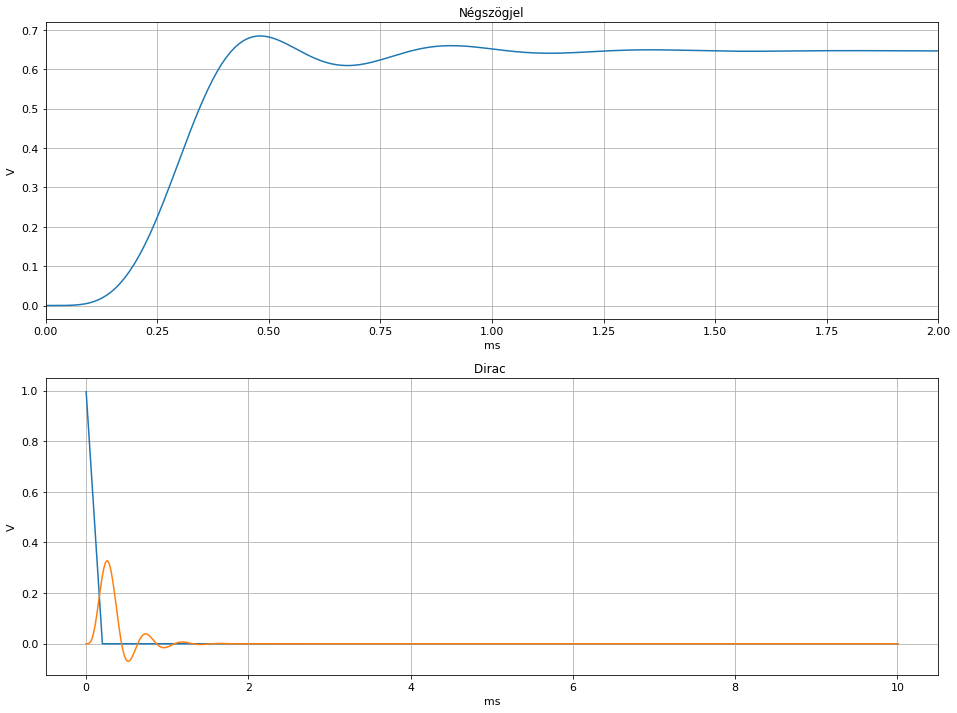

In [41]:
fig, axs = plt.subplots(2,1,figsize=(16,12))

axs[0].set_title("Négszögjel")
axs[0].plot(*Bl4)
axs[0].set_xlabel("ms")
axs[0].set_ylabel("V")
axs[0].set_xlim(0,2)
axs[0].grid()

axs[1].set_title("Dirac ")
axs[1].plot(*int5)
axs[1].plot(*int6)
axs[1].set_xlabel("ms")
axs[1].set_ylabel("V")
axs[1].grid()



Tudtad, hogy a nyuszik, ha  dühösek cukin dobbantanak a hátsó lábukkal? 
https://youtube.com/shorts/Bq9zPGX1Q78?feature=share

## 5. rész - Zajok vizsgálata

Állítsunk elő kétféle zajt, és ábrázoljuk:

* uniform zaj: az időfüggő jel értéke a [-1,1] intervallumon egyenletes eloszlásból származik
* normál eloszlású zaj: a jel értéke 0 átlagú és egységnyi szórású normál eloszlás szerinti

E zajokat $100 ms$ hosszan állítsuk elő, s ebben legyen $8-10000$ adatpontunk!

Utána határozzuk meg ezek autokorrelációs függvényeit és ábrázoljuk!

Határozzuk meg és ábrázoljuk e zajok Fourier spektrumát is!

Vizsgáljuk meg, hogy e zajokból milyen jel keletkezik a sáváteresztő szűrő hatására!
Ábrázoljuk előbb a kimenő jeleket! Utána pedig a kimenő jel Fourier transzformáltját úgy, hogy mindkét zaj esetében egy-egy ábrában hasonlítsuk össze a 3. részben kapott átviteli függvénnyel!